In [134]:
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt

from pdpbox import pdp
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ROCAUC, ConfusionMatrix
from yellowbrick.target import ClassBalance
# import shap

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Exploration

In [135]:
# read in data
raw_df = pd.read_csv("bank-additional-full-correct.csv")
full_df = raw_df.copy(deep=True)

In [136]:
# get a report of the data 
profile = full_df.profile_report()

In [137]:
rejected_variables = profile.get_rejected_variables(threshold=0.9)

In [138]:
profile

In [139]:
# duration feature removed as this number will only be known after the call is made
# despite the report shows great correlation among certain features, we will still keep them in the dataset first
# full_df = full_df.drop(['duration'], axis=1)

In [140]:
# categorical are ordinally encoded
# job
full_df['job'] = full_df['job'].replace({
    'unknown': -1,
    'unemployed': 0,
    'retired': 1,
    'student': 2,
    'housemaid': 3,
    'self-employed': 4,
    'blue-collar': 5,
    'admin.': 6,
    'technician': 7,
    'services': 8,
    'management': 9,
    'entrepreneur': 10
})

In [141]:
# education
full_df['education'] = full_df['education'].replace({
    'unknown': -1,
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree':6
})

In [142]:
# contact
full_df['contact'] = full_df['contact'].replace({
    'cellular': 0,
    'telephone': 1
})

In [143]:
# day of week
full_df['day_of_week'] = full_df['day_of_week'].replace({
    'mon': 0,
    'tue': 1,
    'wed': 2,
    'thu': 3,
    'fri': 4
})

In [144]:
# default
full_df['default'] = full_df['default'].replace({
    'unknown': -1,
    'no': 0,
    'yes': 1
})

In [145]:
# housing
full_df['housing'] = full_df['housing'].replace({
    'unknown': -1,
    'no': 0,
    'yes': 1
})

In [146]:
# loan
full_df['loan'] = full_df['loan'].replace({
    'unknown': -1,
    'no': 0,
    'yes': 1
})

In [147]:
# marital
full_df['marital'] = full_df['marital'].replace({
    'unknown': -1,
    'divorced': 0,
    'single': 1,
    'married': 2
})

In [148]:
# month
full_df['month'] = full_df['month'].replace({
    'mar': 0,
    'apr': 1,
    'may': 2,
    'jun': 3,
    'jul': 4,
    'aug': 5,
    'sep': 6,
    'oct': 7,
    'nov': 8,
    'dec': 9
})

In [149]:
# poutcome
full_df['poutcome'] = full_df['poutcome'].replace({
    'nonexistent': -1,
    'failure': 0,
    'success': 1
})

In [150]:
# outcome
full_df['y'] = full_df['y'].replace({
    'no': 0,
    'yes': 1
})

In [151]:
# replace 999 with -1 to indicate not exist!
full_df['pdays'] = full_df['pdays'].replace(999, -1)

In [152]:
full_df.head()

age  job  marital  education  default  housing  loan  contact  month  \
0   56    3        2          1        0        0     0        1      2   
1   57    8        2          4       -1        0     0        1      2   
2   37    8        2          4        0        1     0        1      2   
3   40    6        2          2        0        0     0        1      2   
4   56    8        2          4        0        0     1        1      2   

   day_of_week  ...  campaign  pdays  previous  poutcome  emp.var.rate  \
0            0  ...         1     -1         0        -1           1.1   
1            0  ...         1     -1         0        -1           1.1   
2            0  ...         1     -1         0        -1           1.1   
3            0  ...         1     -1         0        -1           1.1   
4            0  ...         1     -1         0        -1           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0          93.994          -36.4      4.857         5191  0  
1          93.994          -36.4      4.857         5191  0  
2          93.994          -36.4      4.857         5191  0  
3          93.994          -36.4      4.857         5191  0  
4          93.994          -36.4      4.857         5191  0  

[5 rows x 21 columns]

# Visualise 'decision tree'

In [153]:
# use 2/3 data to train and the rest of the data will be used for validation and evaluation
X_train, X_test, y_train, y_test = train_test_split(full_df.drop('y', axis=1),
                                                    full_df['y'],
                                                    test_size=0.33,
                                                    random_state=42)

In [154]:
# create untuned model with all features
# max depth is included for visualisation purpose
# we do not want the tree to grow to the fullest..
base_model = RandomForestClassifier(max_depth=4,
                                    random_state=42).fit(X_train, y_train)

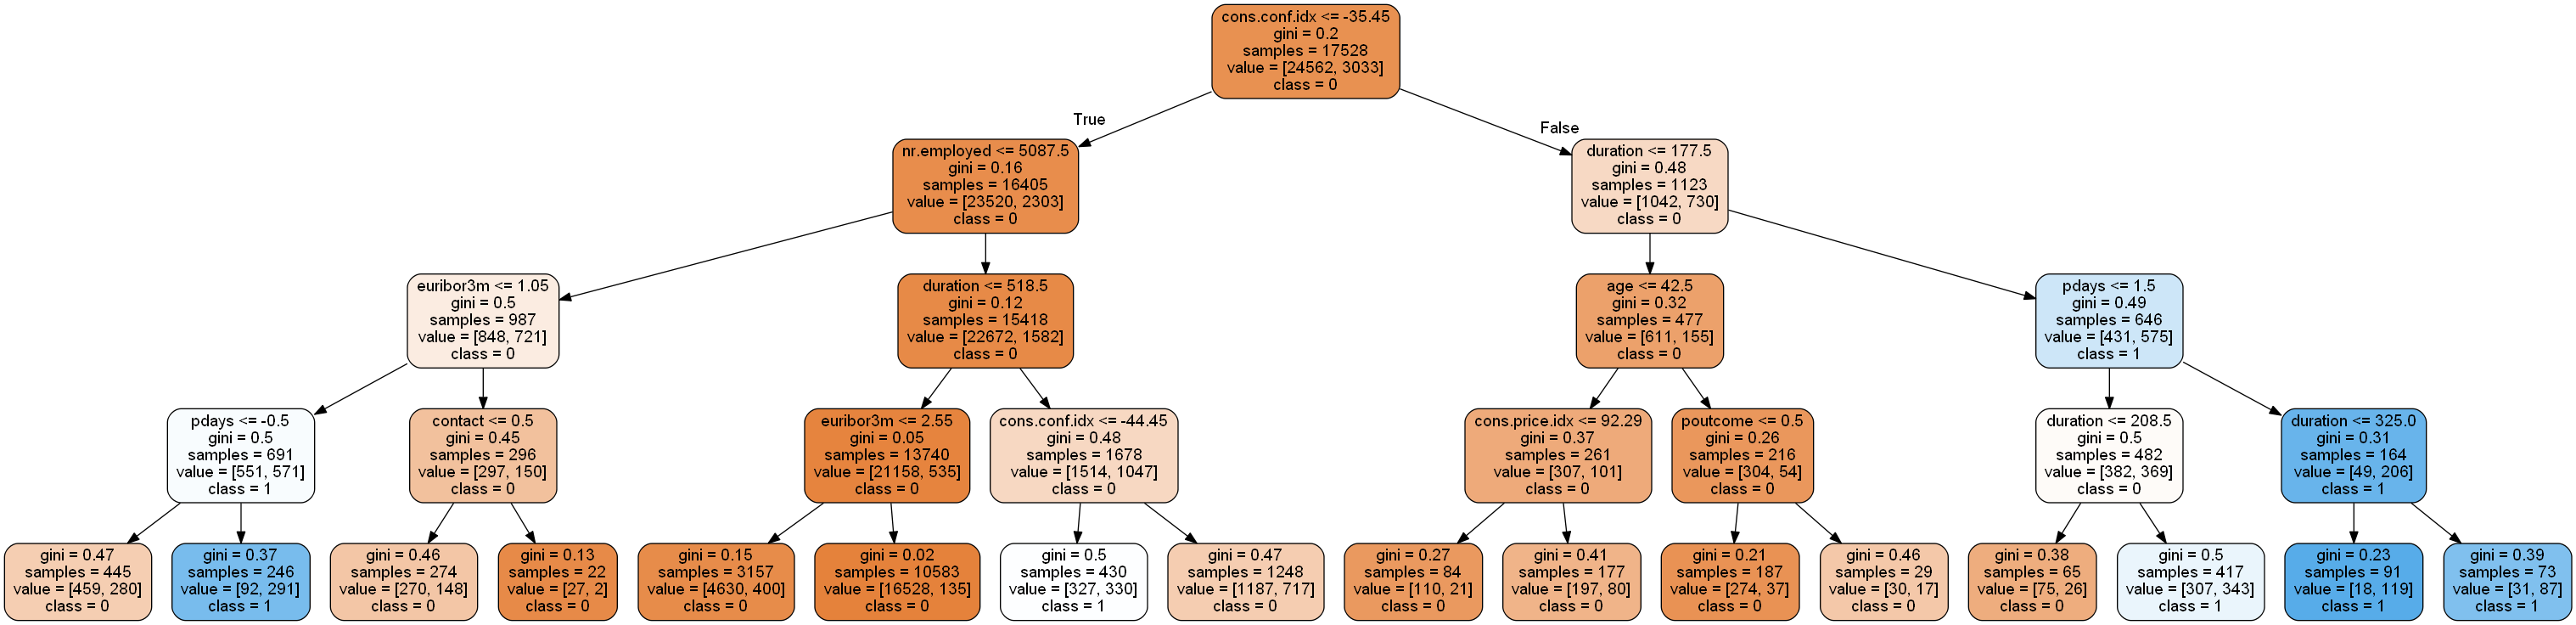

In [155]:
# visualise the first tree in the forest (since it's an ensemble method...)
dot_data = export_graphviz(base_model[0],
                           out_file=None,
                           feature_names=X_train.columns,
                           class_names=['0','1'],
                           rounded=True,
                           proportion=False,
                           precision=2,
                           filled=True)
Image(pydotplus.graph_from_dot_data(dot_data).create_png())

# Model tuning 

### Use self defined class weight

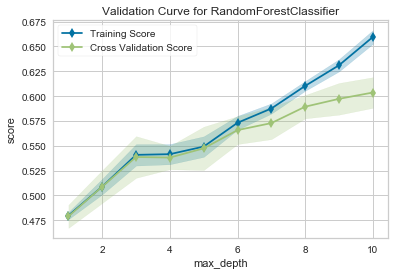

In [156]:
# Create single feature validation curve
# max tree depth from (1-10)
viz = ValidationCurve(RandomForestClassifier(class_weight={0: 1,
                                                           1: 7.88},
                                             random_state=42),
                      param_name="max_depth",
                      param_range=np.arange(1, 11, 1),
                      cv=10,
                      scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

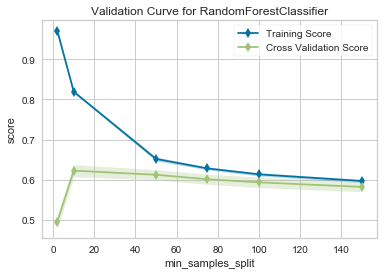

In [157]:
# min sample splits
viz = ValidationCurve(RandomForestClassifier(class_weight={0:1, 1:7.88},
                                             random_state=42), 
                      param_name="min_samples_split",
                      param_range=[2, 10, 50, 75, 100, 150], 
                      cv=10, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

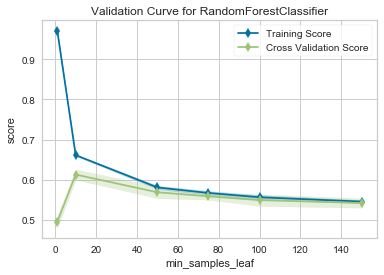

In [158]:
# minimal number of nodes at leaves
viz = ValidationCurve(RandomForestClassifier(random_state=42, 
                                             class_weight={0:1, 1:7.88}), 
                      param_name="min_samples_leaf",
                      param_range=[1, 10, 50, 75, 100, 150], cv=10, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

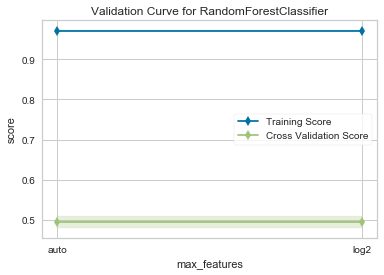

In [159]:
# max features to be used
viz = ValidationCurve(RandomForestClassifier(random_state=42, 
                                             class_weight={0:1, 1:7.88}), 
                      param_name="max_features",
                      param_range=['auto', 'log2'], cv=10, scoring="f1")
viz.fit(X_train, y_train)
viz.poof()

In [160]:
%%time
# Randomised Grid Search
tuned_model = RandomForestClassifier(n_estimators=100,
                                     random_state=42,
                                     class_weight={0:1, 1:7.88},
                                     n_jobs=7)

# specify parameters and distributions to sample from
param_dist = {"max_depth": np.arange(1, 20, 1),
              "min_samples_split": np.arange(2, 100, 2),
              "min_samples_leaf": np.arange(1, 100, 2)}

# run randomized search, 95% of time, 60 iterations will lead to a top 5% result
# see https://stats.stackexchange.com/questions/160479/praxctical-hyperparameter-optimization-random-vs-grid-search
random_search = RandomizedSearchCV(tuned_model, param_distributions=param_dist,
                                   n_iter=60, cv=5, iid=False, scoring="f1", random_state=42)

random_search.fit(X_train, y_train)

Wall time: 2min 48s


In [161]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [162]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.609 (std: 0.007)
Parameters: {'min_samples_split': 64, 'min_samples_leaf': 1, 'max_depth': 19}

Model with rank: 2
Mean validation score: 0.601 (std: 0.010)
Parameters: {'min_samples_split': 8, 'min_samples_leaf': 19, 'max_depth': 16}

Model with rank: 3
Mean validation score: 0.594 (std: 0.010)
Parameters: {'min_samples_split': 46, 'min_samples_leaf': 7, 'max_depth': 9}



In [163]:
tuned_model = random_search.best_estimator_

# Explain features

### Feature Importance

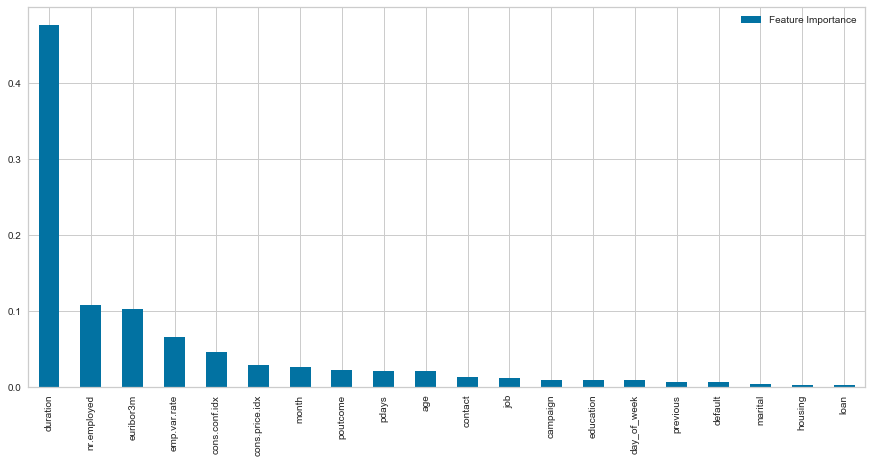

In [173]:
# basic feature importance
pd.DataFrame(tuned_model.feature_importances_, 
             index=X_train.columns,
             columns=['Feature Importance']).sort_values(by='Feature Importance', 
                                                         ascending=False).plot(kind='bar', 
                                                                               figsize=(15,7))

### PDP - partial independence plot

In [174]:
# partial dependency plots
def individual_pdp(model, feature_list, train_df):
    for feature in feature_list:
        pdp_model = pdp.pdp_isolate(model=model, dataset=train_df, model_features=feature_list, feature=feature)
        fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_model, feature_name=feature, center=True, x_quantile=True, 
                                 ncols=3, plot_lines=True, frac_to_plot=100)

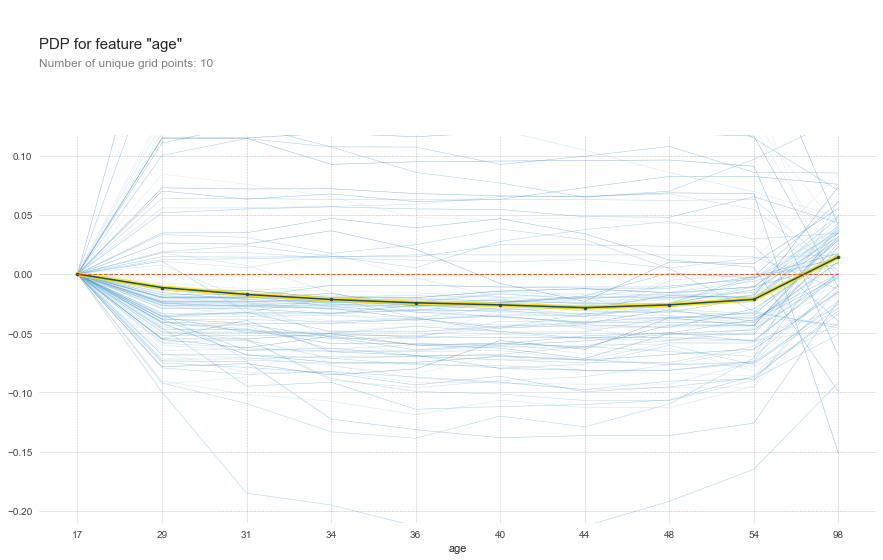

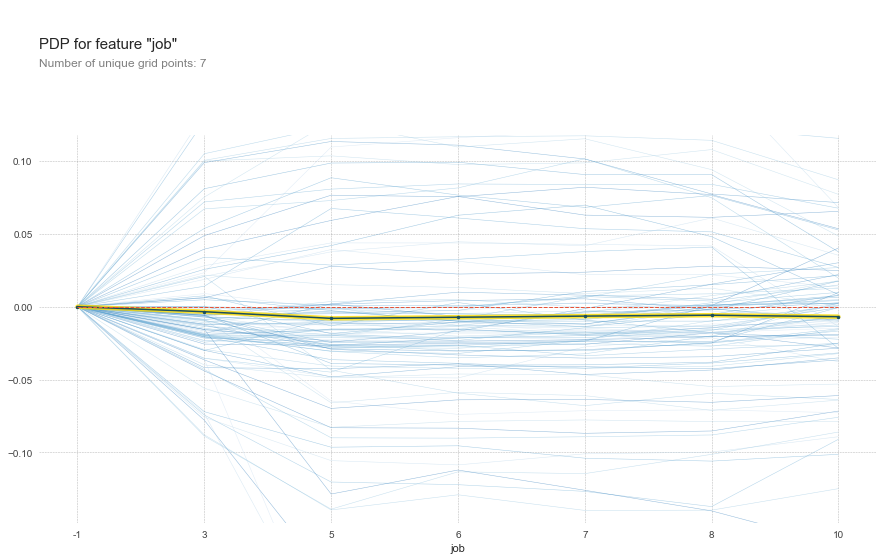

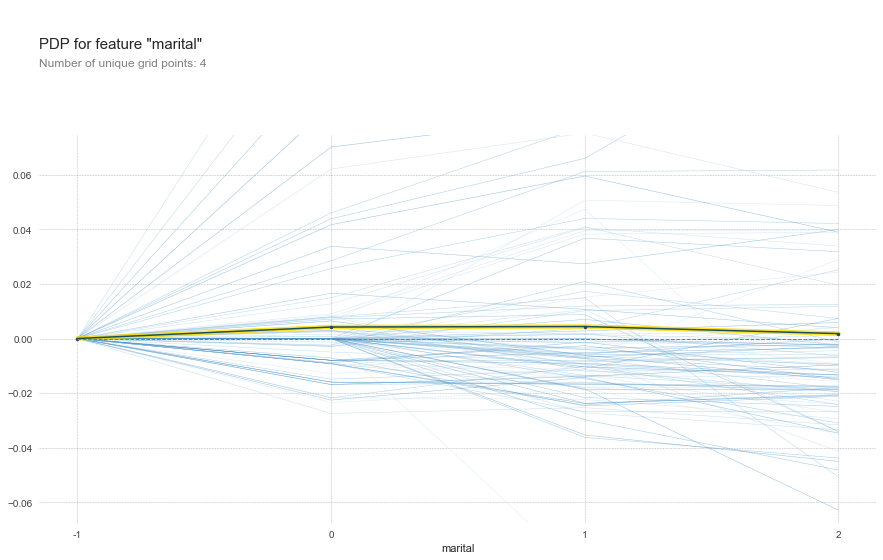

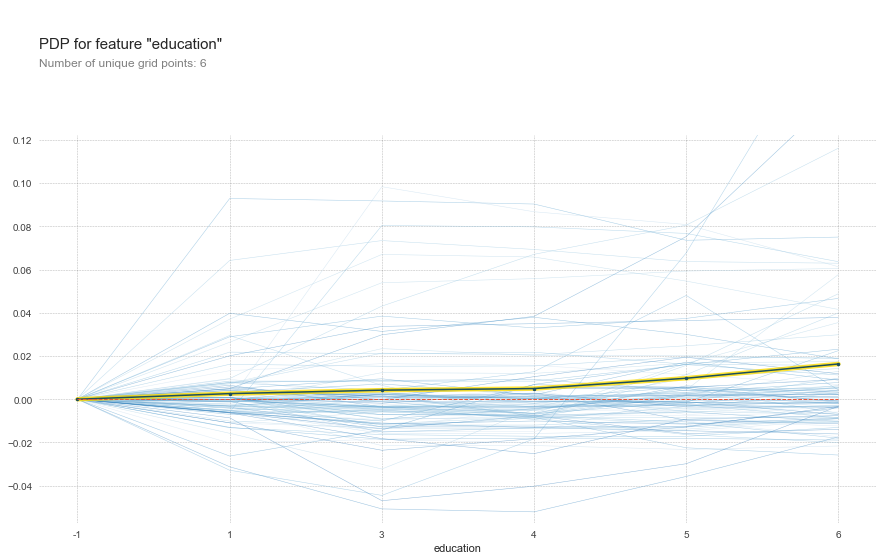

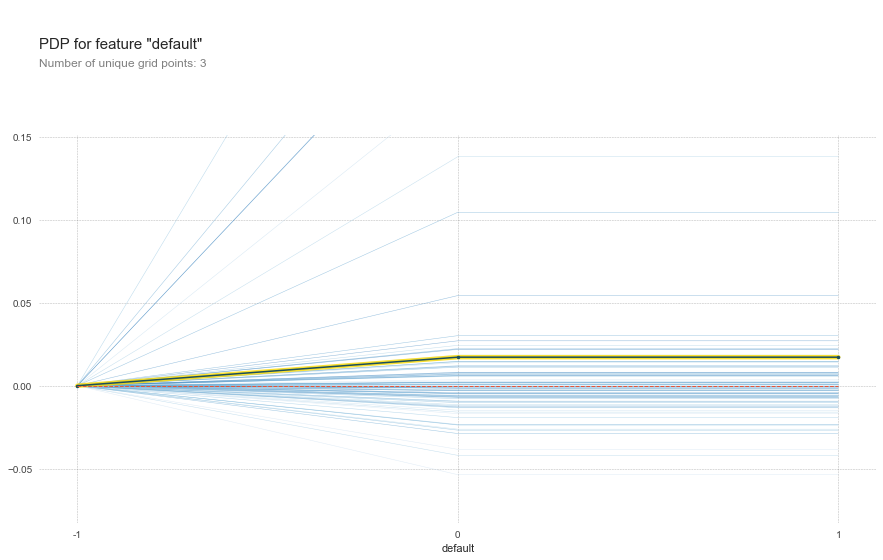

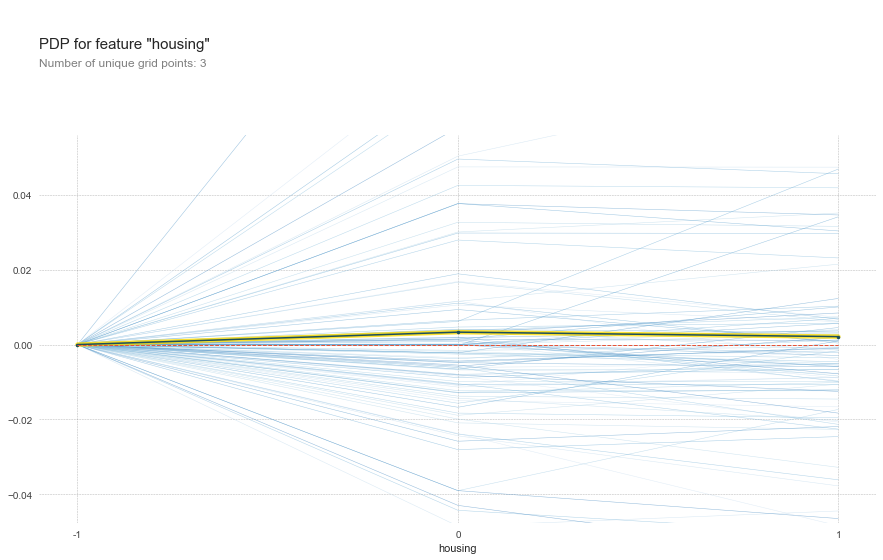

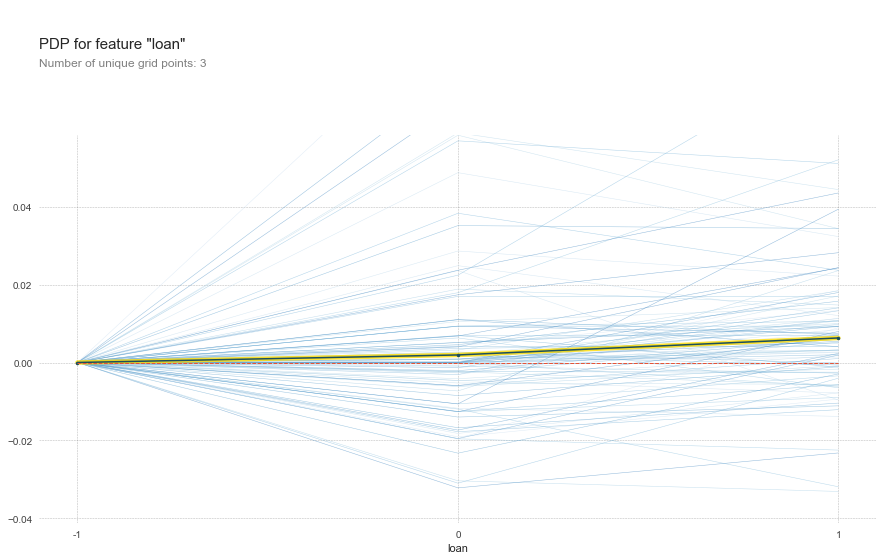

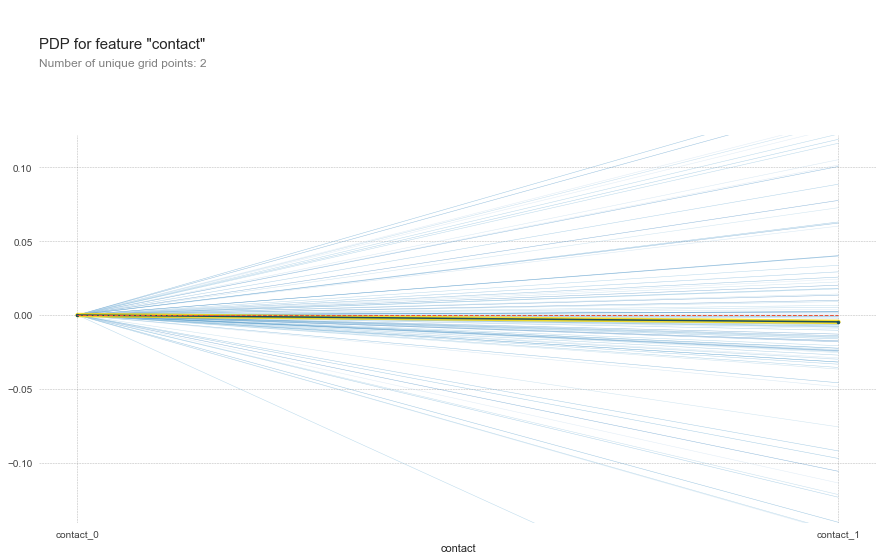

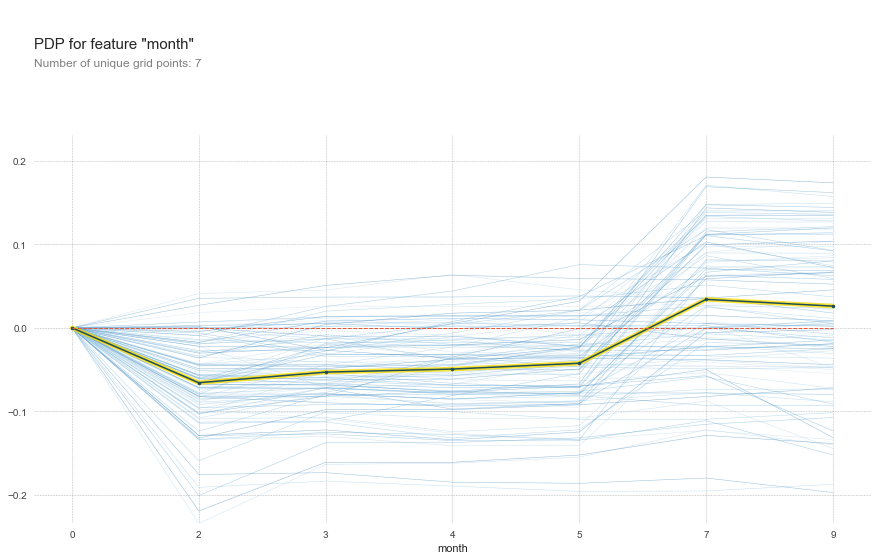

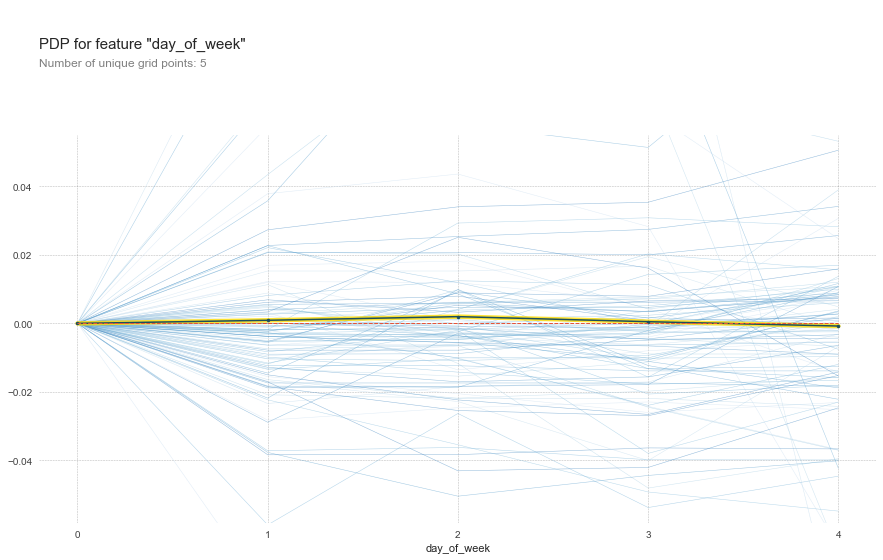

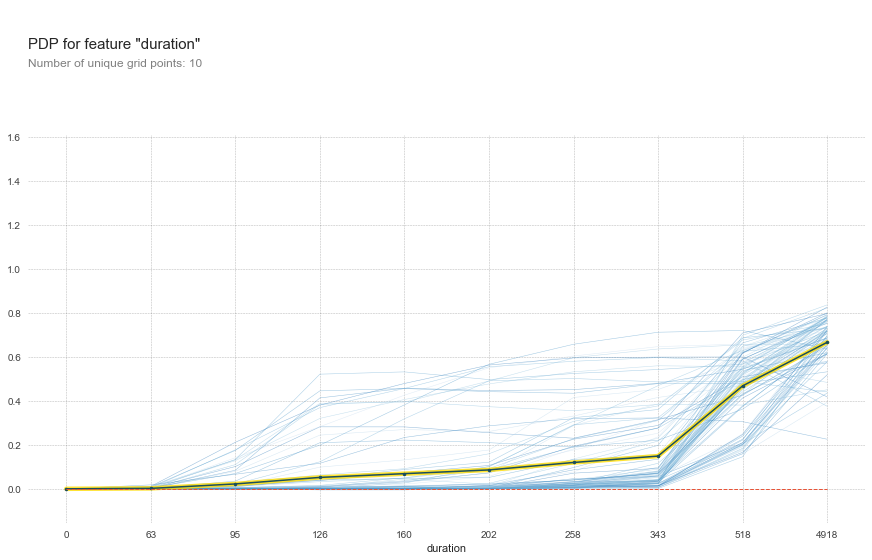

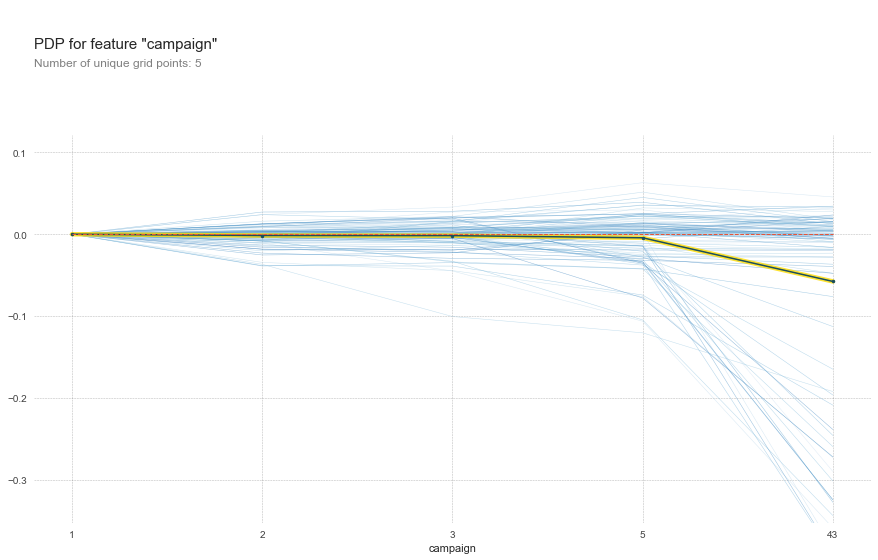

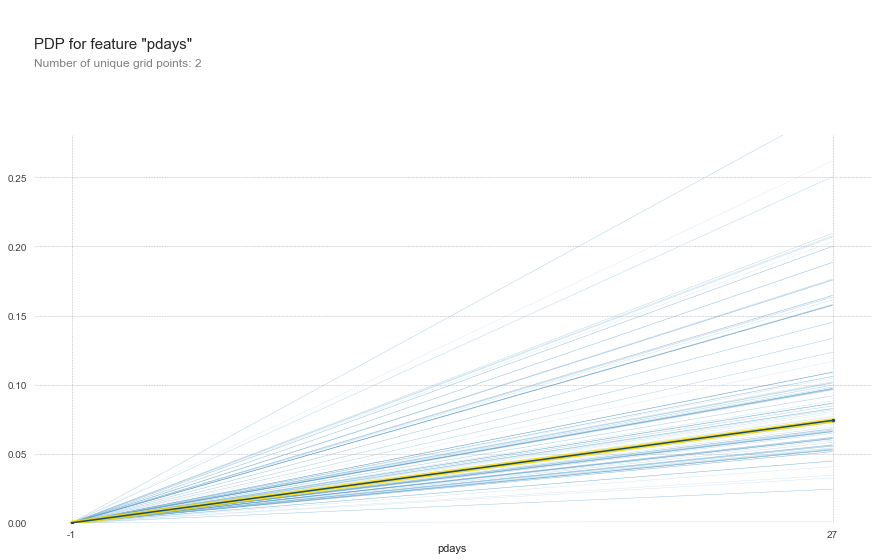

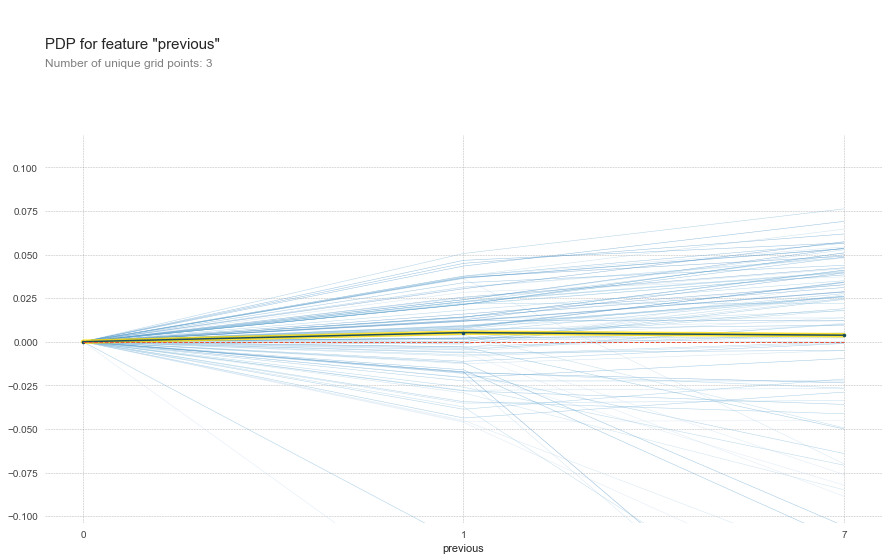

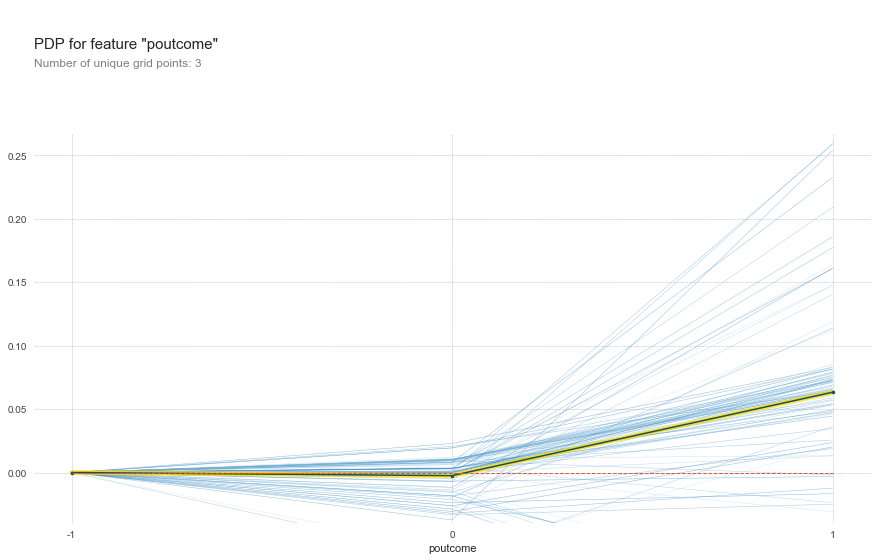

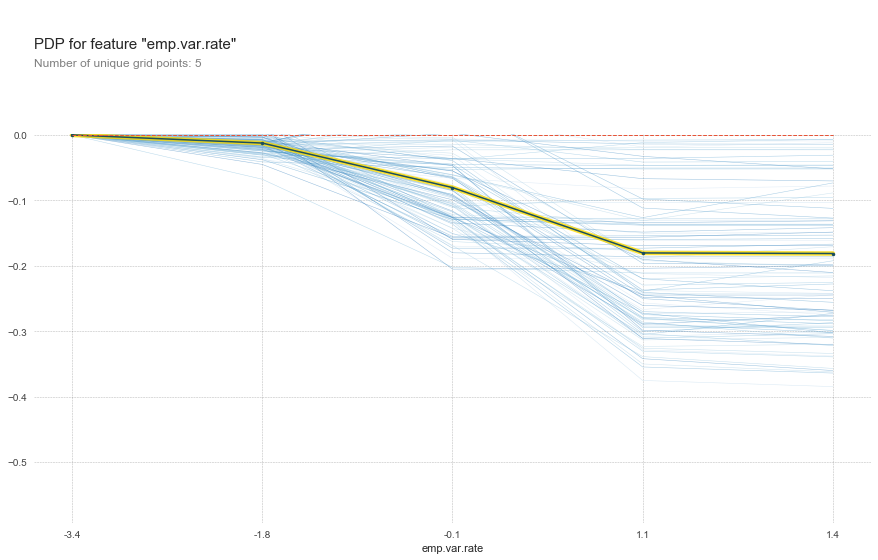

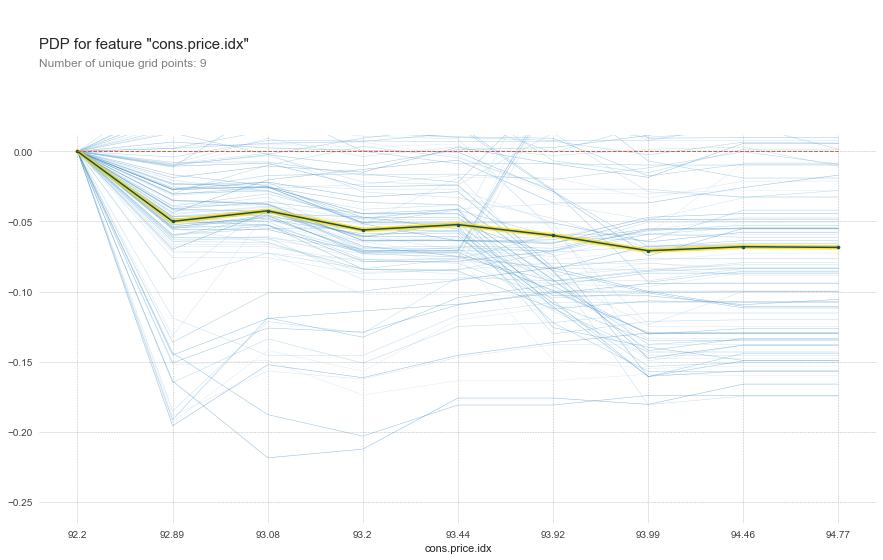

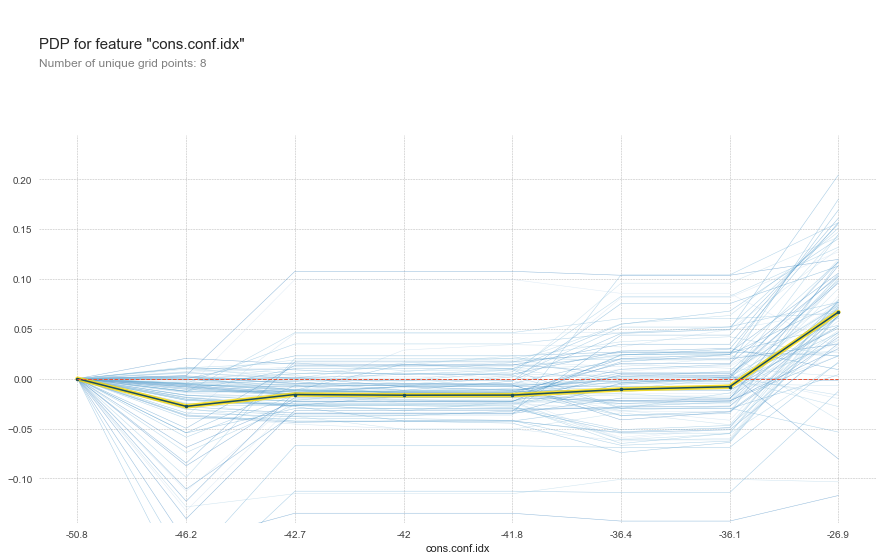

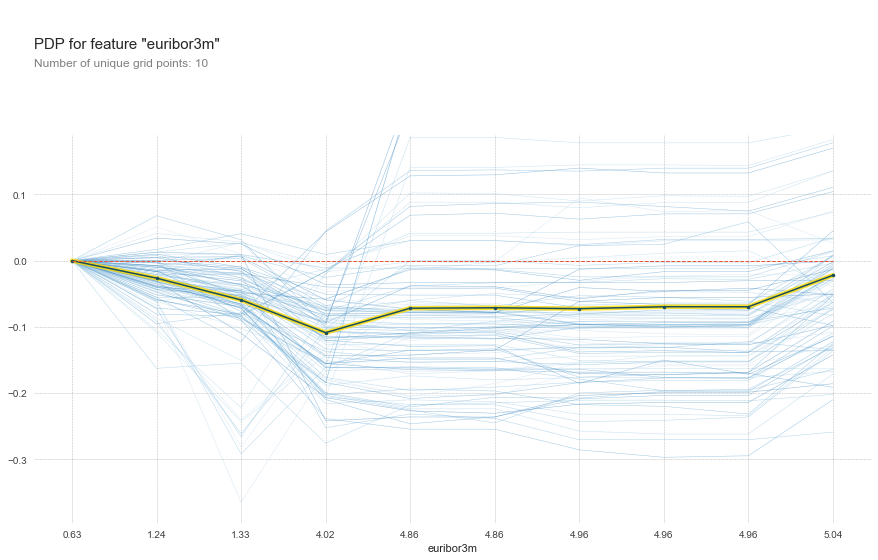

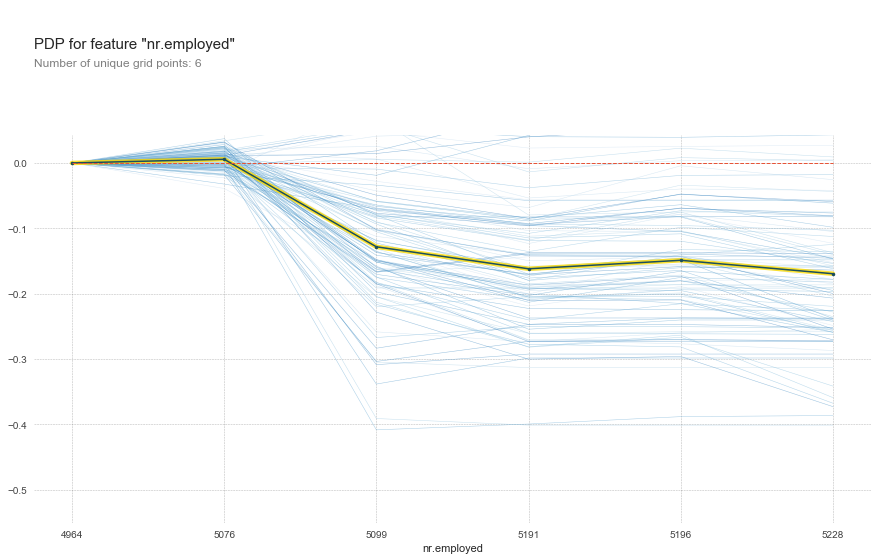

In [175]:
individual_pdp(tuned_model, X_train.columns,
               pd.concat([X_train, y_train], axis=1))

In [176]:
def interaction_pdp(model, feature_list, train_df, target_features):
    pdp_model = pdp.pdp_interact(model=model, dataset=train_df, model_features=feature_list, 
                                 features=target_features, num_grid_points=[10, 10], 
                                 percentile_ranges=[None, None], n_jobs=5)
    fig, axes = pdp.pdp_interact_plot(pdp_model, target_features, 
                                      plot_type='contour', x_quantile=True, ncols=2, plot_pdp=True)

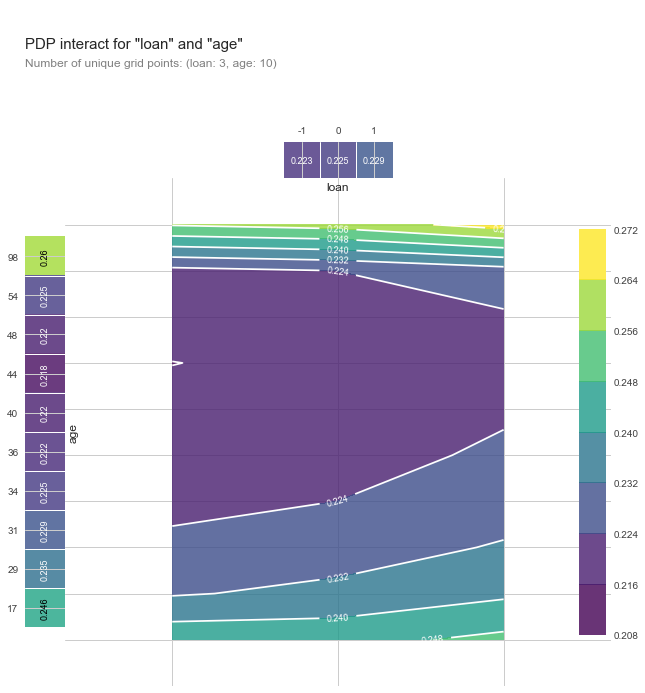

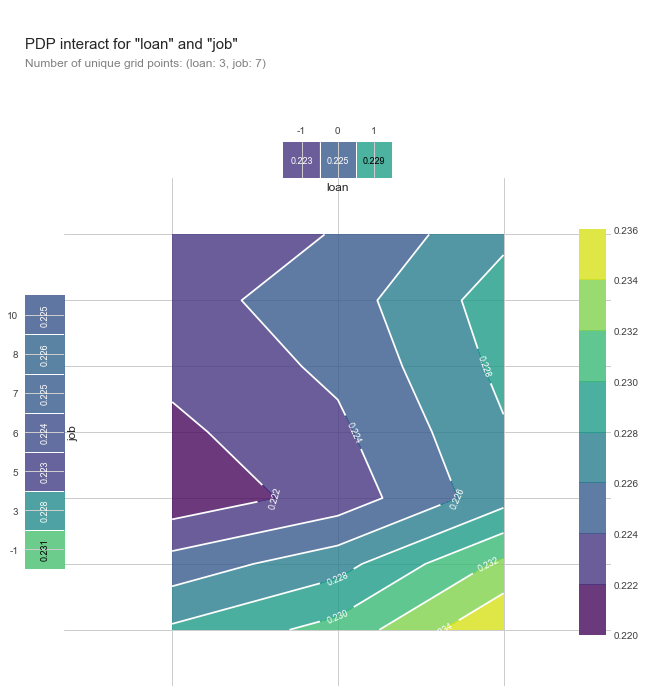

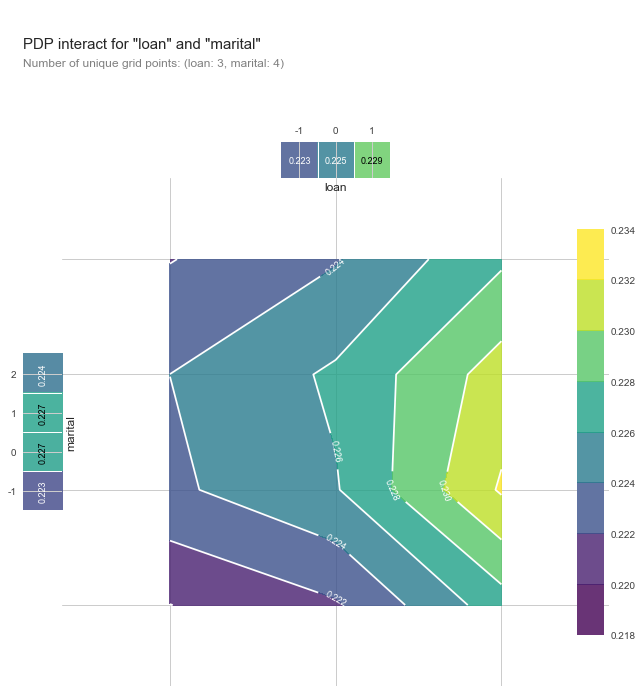

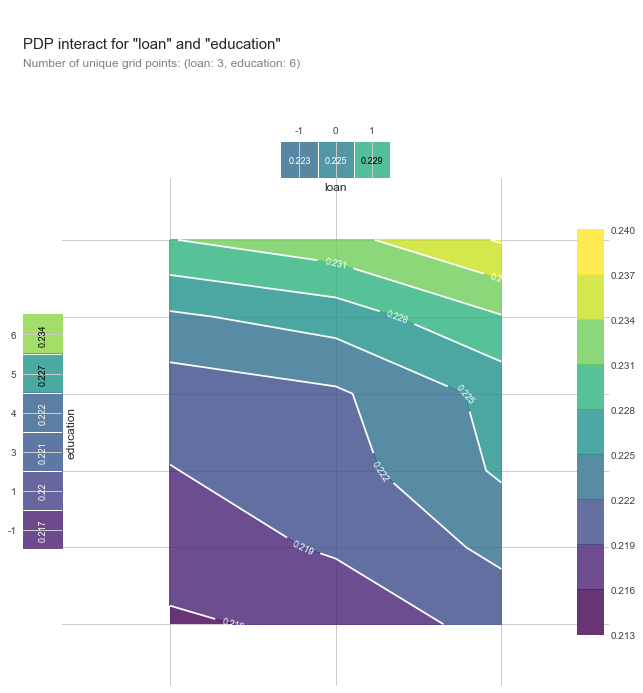

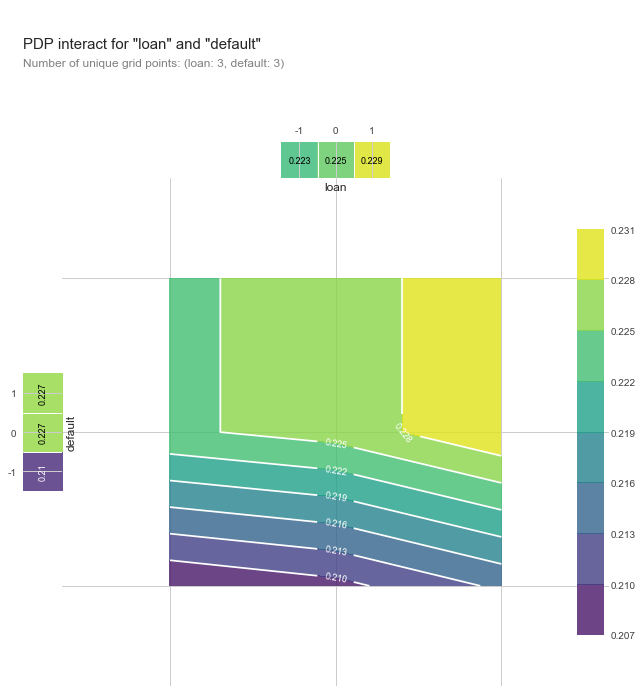

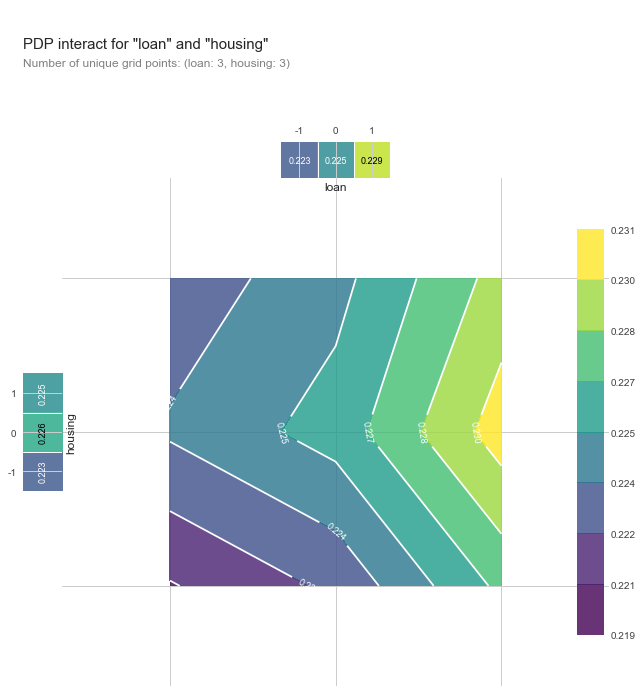

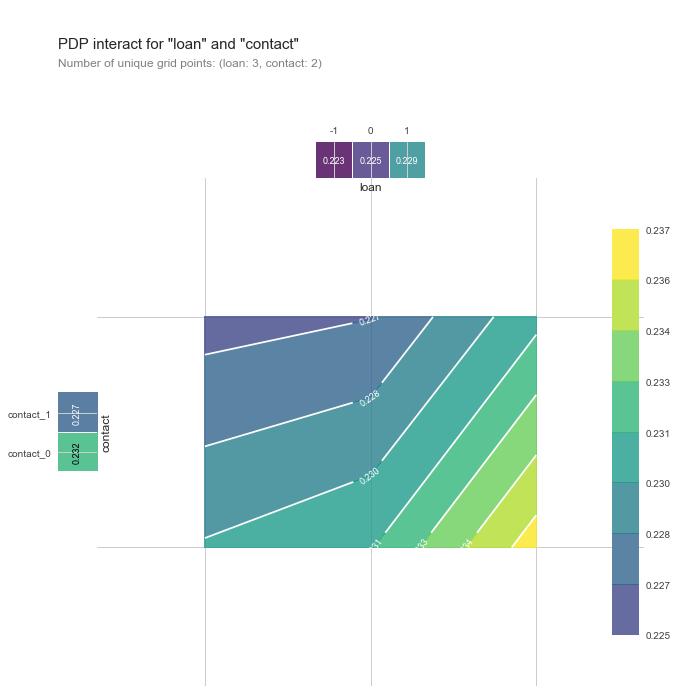

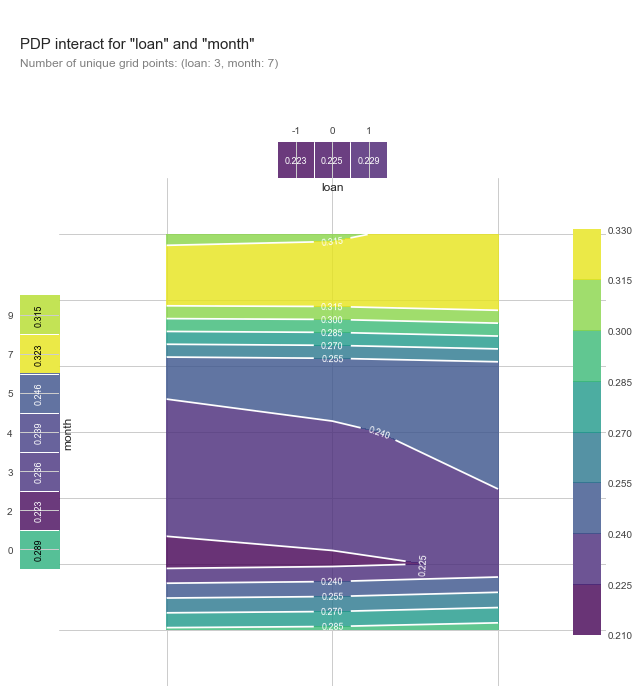

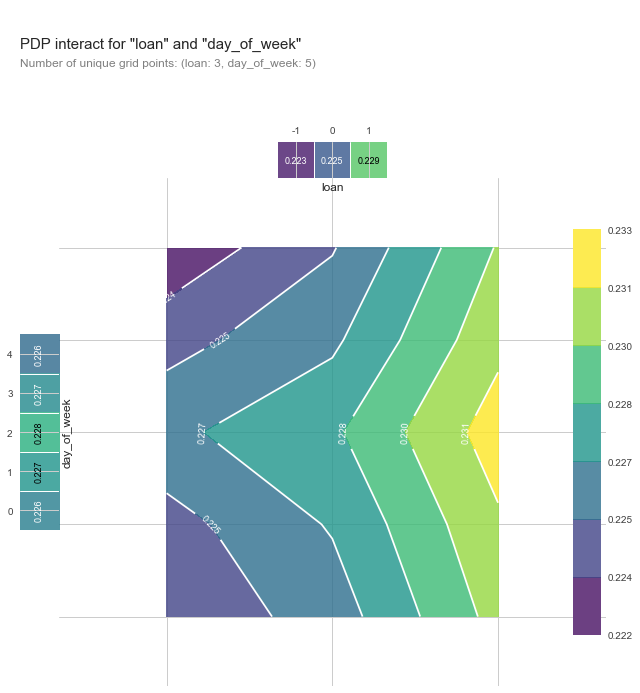

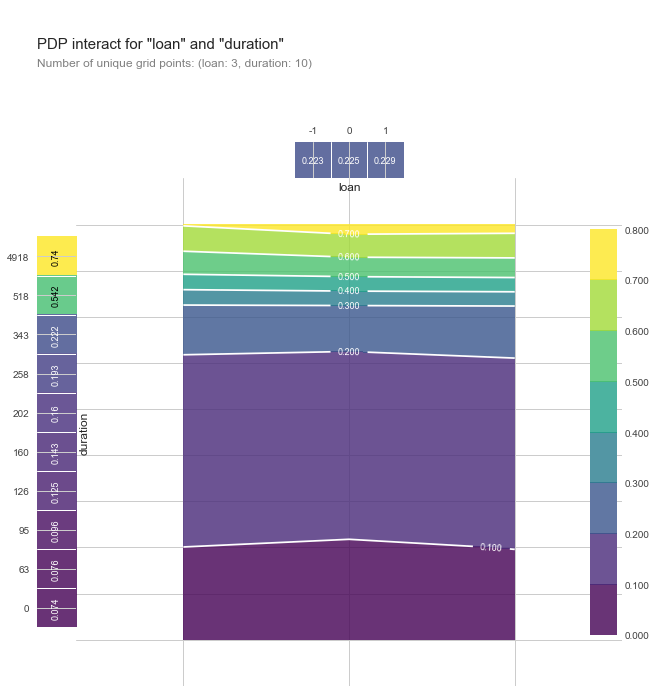

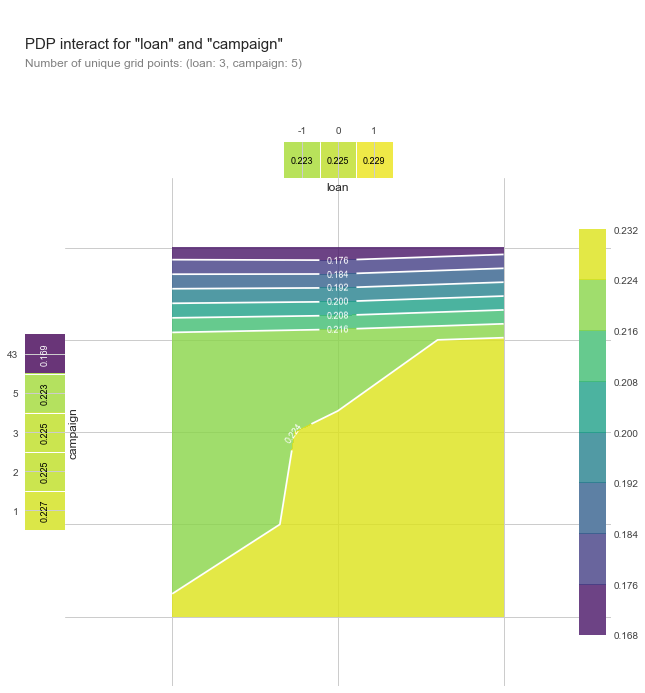

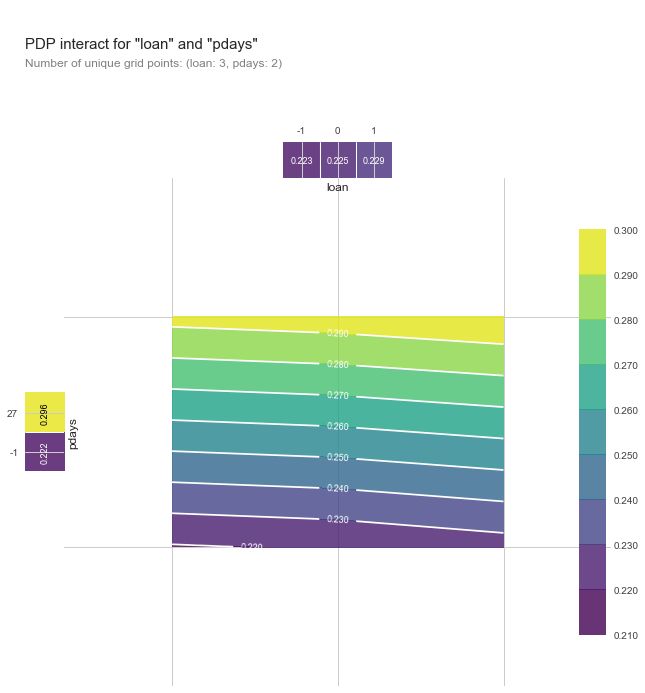

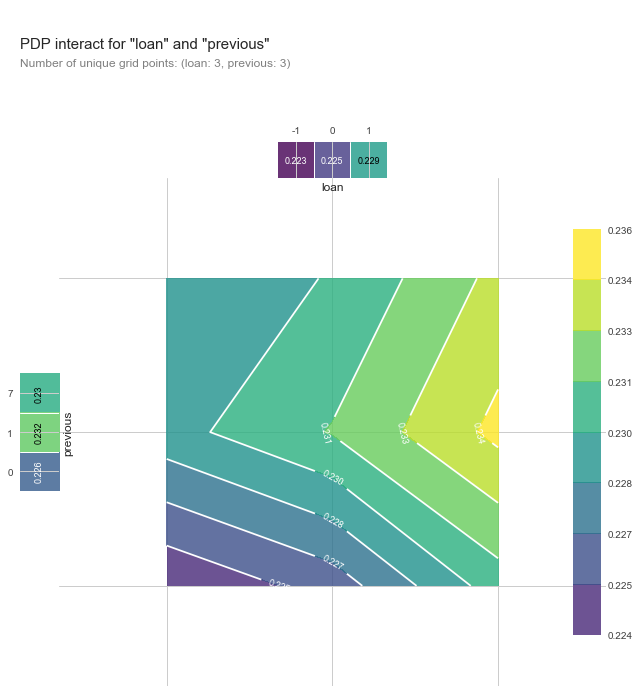

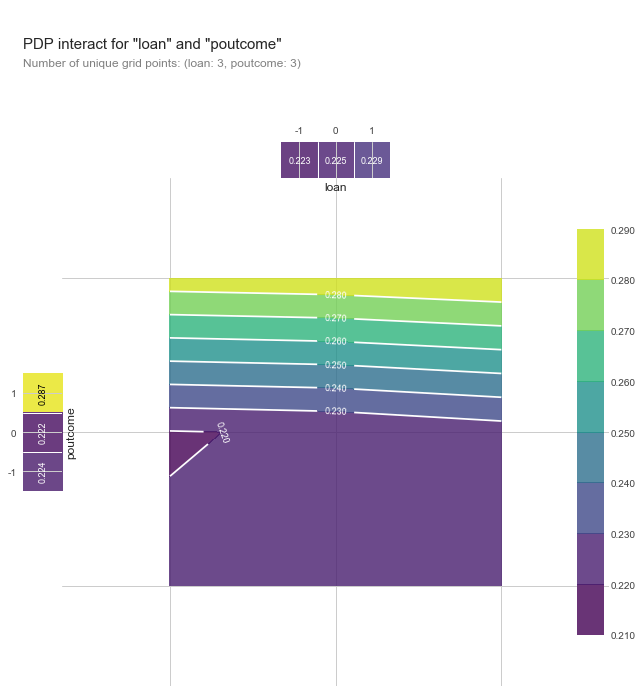

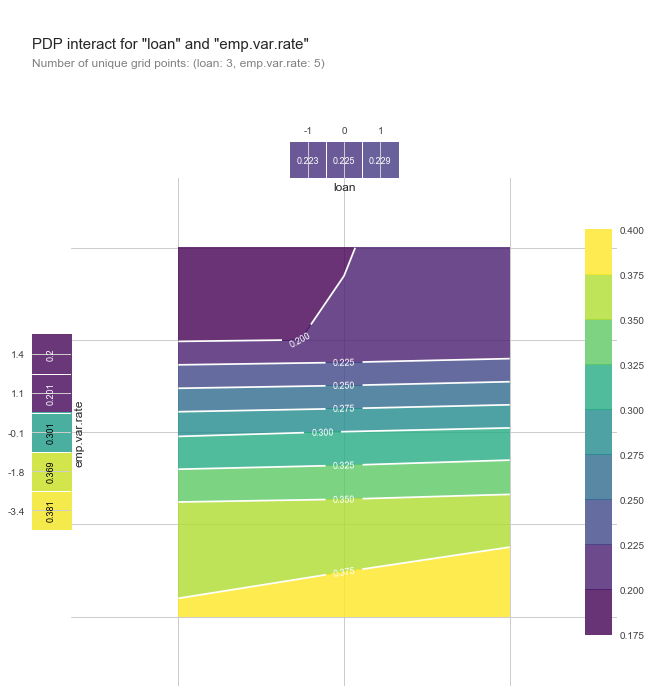

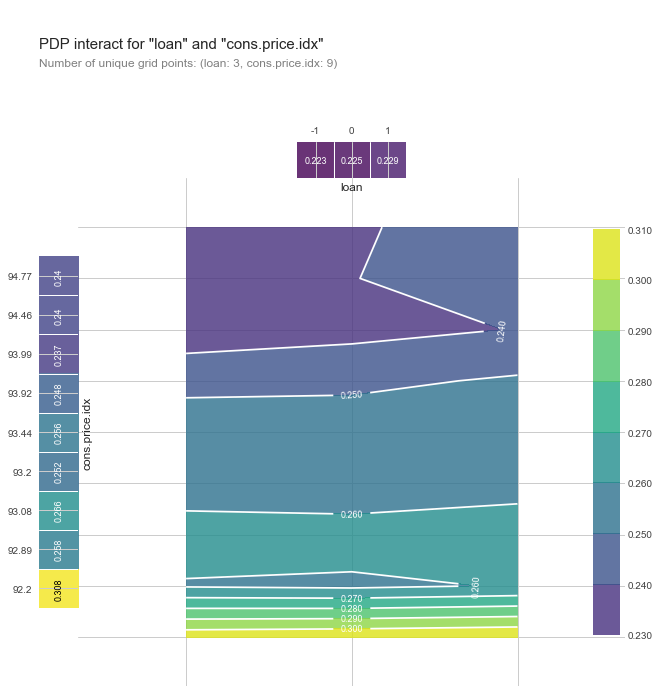

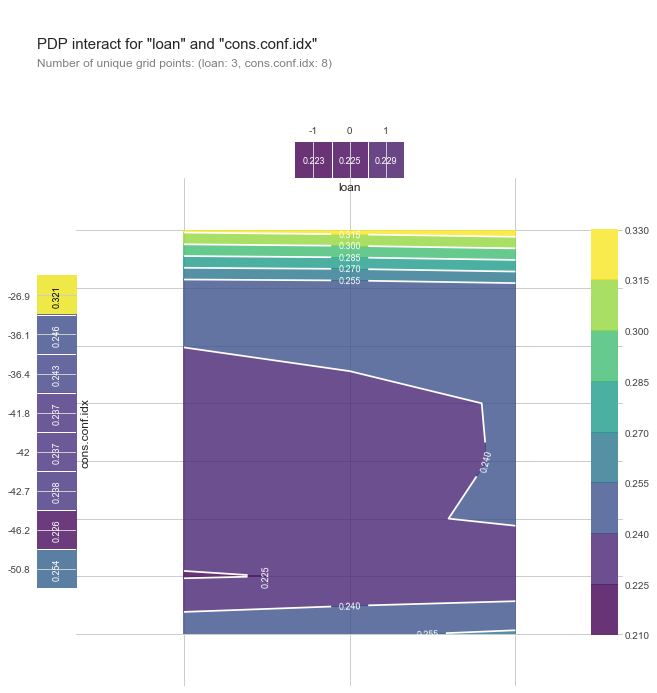

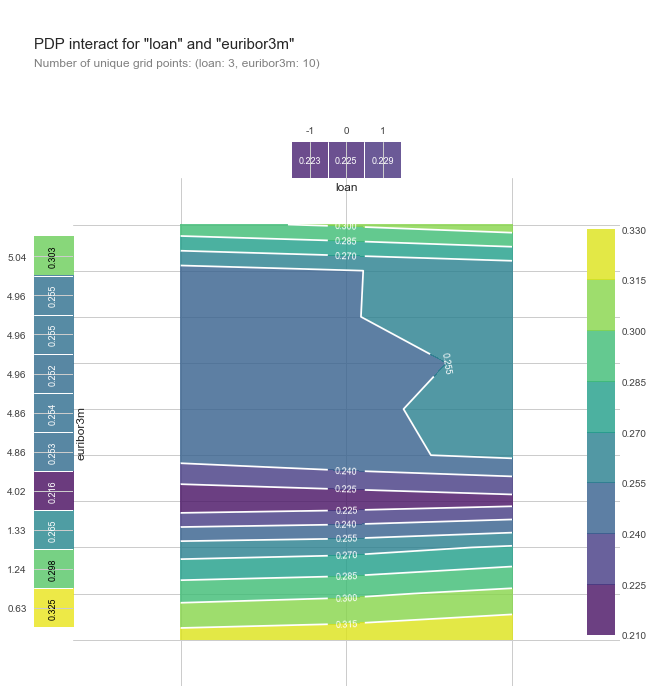

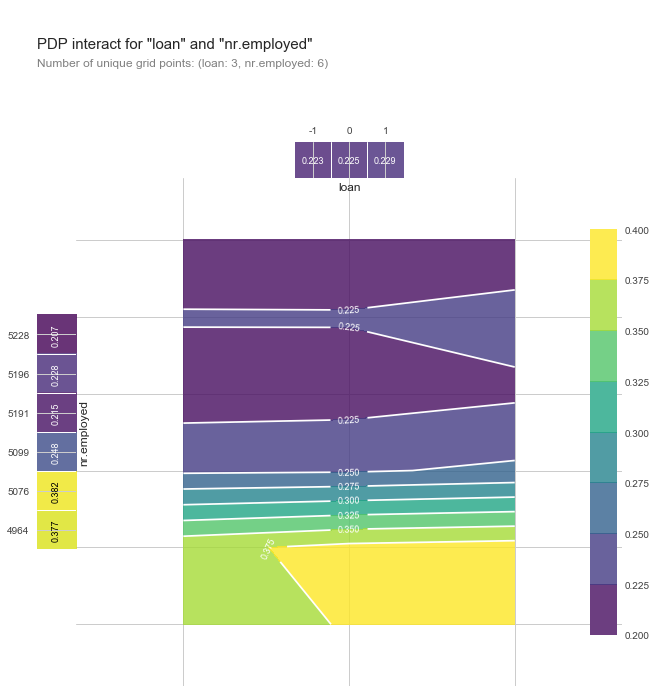

In [177]:
for i in X_train.drop('loan', axis=1).columns:
    interaction_pdp(tuned_model, X_train.columns, pd.concat([X_train, y_train], axis=1), ['loan', i])

### SHAP Values

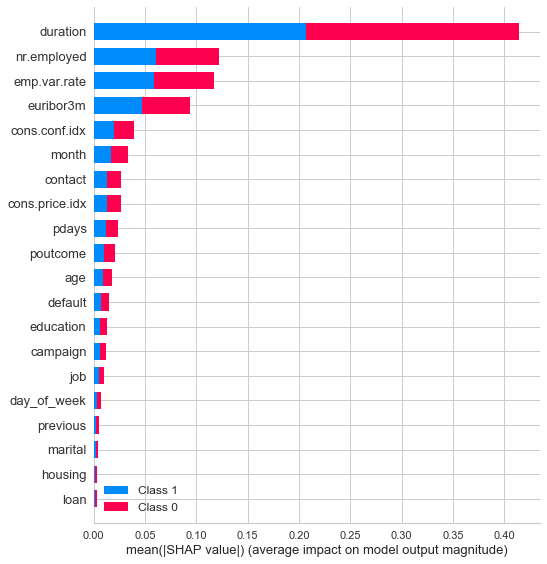

In [178]:
# explain model using shap (shapley additive explanations), a better alternative to 'feature importance'
# but this takes freaking long to run
shap.initjs()

explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# Model evaluation

### classification report comparison

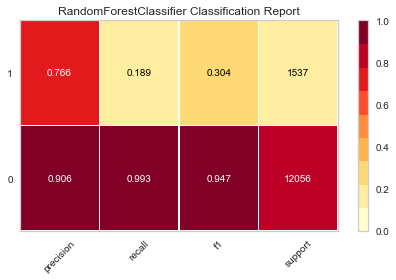

In [169]:
reporter = ClassificationReport(base_model, classes=[0,1], support=True)

reporter.fit(X_train, y_train)
reporter.score(X_test, y_test)
reporter.poof()

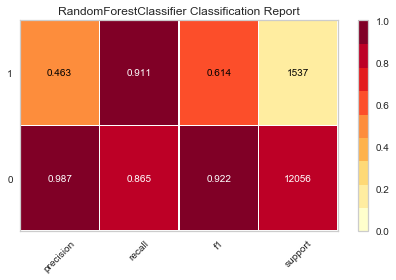

In [170]:
reporter = ClassificationReport(tuned_model, classes=[0,1], support=True)

reporter.fit(X_train, y_train)
reporter.score(X_test, y_test)
reporter.poof()

### prediction error 

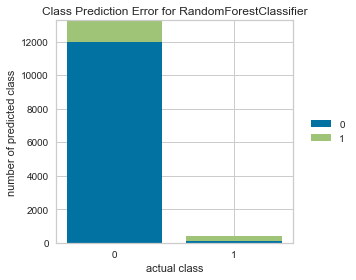

In [168]:
# Create class prediction error
visualizer = ClassPredictionError(base_model, classes=[0,1])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

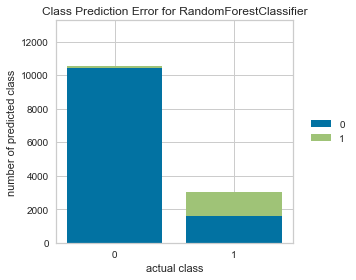

In [167]:
# Create class prediction error
visualizer = ClassPredictionError(tuned_model, classes=[0,1])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

### ROCAUC

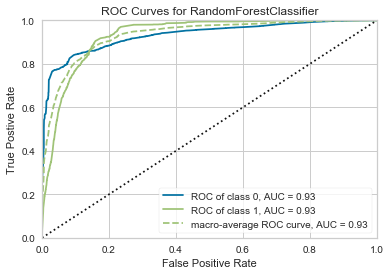

In [165]:
visualizer = ROCAUC(base_model, classes=[0,1], micro=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

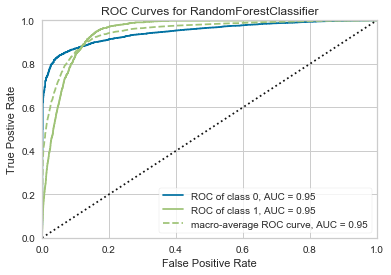

In [166]:
visualizer = ROCAUC(tuned_model, classes=[0,1], micro=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

### Confusion Matrix

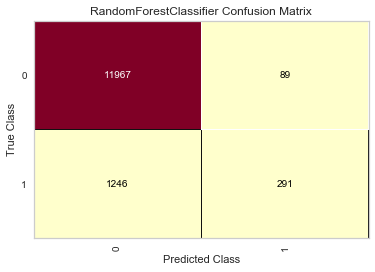

In [171]:
visualizer = ConfusionMatrix(base_model, classes=[0,1])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

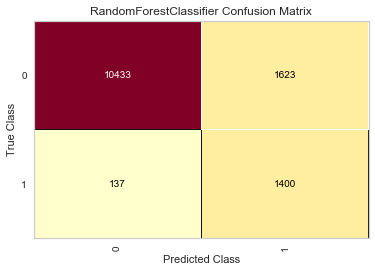

In [172]:
visualizer = ConfusionMatrix(tuned_model, classes=[0,1])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()